# Information score

I want to learn more about information score, as defined by Skaggs et al. in a 1996 paper in Hippocampus.

My questions are the following

* Can one get a negative information score?
* What is the effect of different ranges of occupancy or number of spikes?

We first define a function to calculate the spatial information score.

The formula is according to twitter: "https://twitter.com/KevinAllenLab/status/1316732959391731712?ref_src=twsrc%5Etfw"

\begin{equation*}
Info(x) = \sum_{n=1}^{N} p_i \frac{\lambda_i}{\lambda} log2 \frac{\lambda_i}{\lambda}
\end{equation*}

In [222]:
import numpy as np

def spatialInformationScore(spikes,times,meanRateOcc=True):
    """
    spikes: array containing the number of spikes per spatial bin
    times: time spent in each bin, in seconds
    meanRateOcc: boolean, if True will calculate the mean rate :  spikes.sum()/times.sum(), otherwise rate.mean()
    """
    # Check if there are bins with a time of 0, get rid of them
    # after all, there are many other bins in the world that were not visited and were not included
    spikes = spikes[times>0]
    times = times[times>0]
    
        
    # We need the firing rate per bin, defined as spikes/time
    rate = spikes/times
    
    # mean rate of the cell
    # I presume this should take into account the occupancy in each bin
    if meanRateOcc:
        mrate = spikes.sum()/times.sum()
    else:
        mrate = rate.mean()
    
    
    # probability to occupy a bin
    prob=times/times.sum()
     
    # one issue is that np.log2 of 0 is -inf.
    # when this occurs because rate is 0, then -inf is multiplied by 0.
    # so we can just get rid of these in the summation
    
    index = rate>0
    return sum(prob[index] * (rate[index]/mrate) * np.log2(rate[index]/mrate))
 
    
   

## Keep splitting the environment

Let's keep the occupancy fixed at 1 sec per bin for now.

Imagine that the cell fires only in one of 2 bins, this should give us 1 bit per spike.
If we had 4 bins and the cell fires only in 1, then this is 2 bits per spike.

Let' have a look at how information score would change as a function of the number of bins.

For 256 bins we get a spatial info score of 8.0.


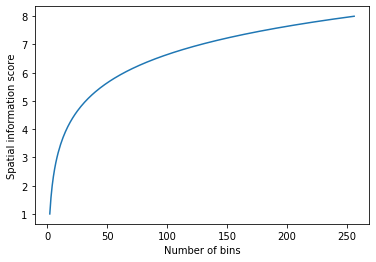

In [223]:
%matplotlib inline
from matplotlib import pyplot as plt
maxBins=256

Info = np.zeros(len(range(2,maxBins+1)))

for x in range(2,maxBins+1):
    spikes=np.zeros(x)
    times=np.ones(x)
    spikes[0]=1 # add a spike in one bin
    Info[x-2] = spatialInformationScore(spikes,times)

print("For {} bins we get a spatial info score of {}.".format(maxBins, np.max(Info)))
plt.plot(np.arange(2,maxBins+1),Info)
plt.xlabel("Number of bins")
plt.ylabel("Spatial information score")
plt.show()

This make intiutive sense, as you can represent 256 numbers with 8 bits.

## Random occupancy and spike counts

Now we will create random spikes and times arrays by sampling different poisson distributions.

We manipulate the lambda of the poisson distribution to see the effect of manipulating the spike and time values without explicitely encoding anything.

I was curious about why people sometimes report negative values with this formula. It might have to do with how the mean firing rate is calculated. There are 2 possible ways.

* Mean of the firing rate bins
* Mean rate as in the total number of spikes emitted divided by the recording time

In the function, I created an argument to change from one way to the other.


0.24066162745061528
0.061908167844203124


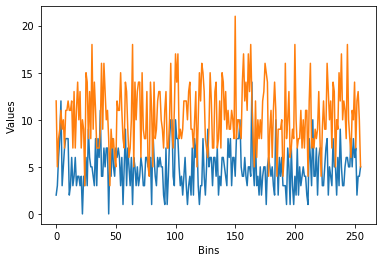

In [248]:
nBins=256
spikes = np.random.poisson(5,nBins)
times = np.random.poisson(10,nBins)
print(spatialInformationScore(spikes,times,meanRateOcc=True))
print(spatialInformationScore(spikes,times,meanRateOcc=False))

## plot the spikes and time arrays
plt.plot(spikes)
plt.plot(times)
plt.xlabel("Bins")
plt.ylabel("Values")
plt.show()

It does not look like it is encoding anything, as expected.

In [245]:
nBins=256 # number of bins in the map
nIters=100 # number of calls to the Info function
Info = np.zeros(nIters) # to store the Info scores
maxLambda=20 # for our poisson distribution
medianInfo = np.zeros(shape=(maxLambda,maxLambda,2)) # to store the median Info score per lambda conditions
for b in range(2):
    for s in range(1,maxLambda+1): # loop for spikes
        for t in range(1,maxLambda+1): # loop for times
            for x in range(nIters):
                spikes = np.random.poisson(s,nBins)
                times = np.random.poisson(t,nBins)
                Info[x] = spatialInformationScore(spikes,times,meanRateOcc=bool(b))
            medianInfo[t-1,s-1,b] = np.median(Info)


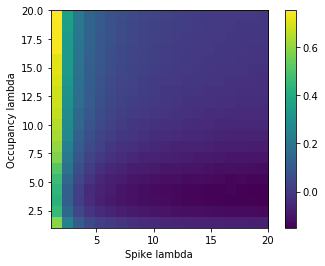

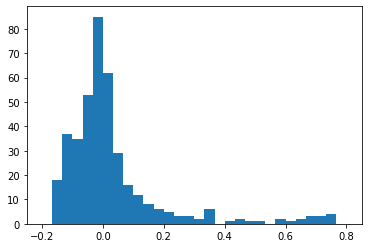

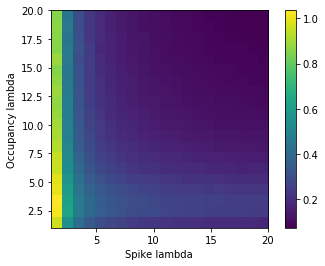

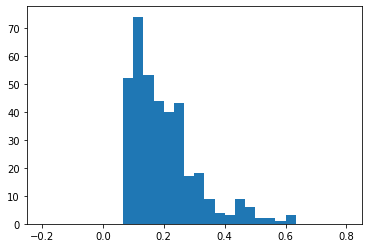

In [246]:
plt.imshow(medianInfo[:,:,0],extent=[1,maxLambda,1,maxLambda],origin='lower')
plt.xlabel("Spike lambda")
plt.ylabel("Occupancy lambda")
plt.colorbar()
plt.show()

plt.hist(medianInfo[:,:,0].reshape((-1,1)),bins=30,range=[-0.2,0.8])
plt.show()

plt.imshow(medianInfo[:,:,1],extent=[1,maxLambda,1,maxLambda],origin='lower')
plt.xlabel("Spike lambda")
plt.ylabel("Occupancy lambda")
plt.colorbar()
plt.show()

plt.hist(medianInfo[:,:,1].reshape((-1,1)),bins=30,range=[-0.2,0.8])
plt.show()